# ArcFace Loss (Additive Angular Margin Loss)

## Теория ArcFace

В случае с обучением на задачу классификации первая подходящая лосс-функция, которая нам приходит в голову — Cross-Entropy. И на ней действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые лосс-функции, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших считается ArcFace Loss (Additive Angular Margin Loss).

Этот лосс — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.



**Доплитература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

## Другие лоссы

Кроме ArcFace, есть еще много разных вариантов лоссов для задачи face recognition. Некоторые из них можно найти, например, [тут](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w48/Hsu_A_Comprehensive_Study_on_Loss_Functions_for_Cross-Factor_Face_Recognition_CVPRW_2020_paper.pdf). Вы можете попробовать реализовать другие лосс-функции в этом проекте в качестве дополнительного задания.

Кроме этого, можно миксовать лосс-функции. Например, обучать нейросеть на сумме ArcFace и TripletLoss. Часто так выходит лучше, чем если обучать на каком-то одном лоссе.

# Датасет

В качестве датасета нужно использовать картинки из CelebA, выровненные при помощи своей модели из задания 1. Очень желательно их еще кропнуть таким образом, чтобы нейросети поступали на вход преимущественно только лица без какого либо фона, частей тела и прочего. Целиком брать весь датасет CelebA не обязательно, он слишком большой.

Если планируете делать дополнительное задание на Identificaton rate metric, то **обязательно разбейте заранее датасет на train/val или train/val/test.** Это нужно сделать не только на уровне кода, а на уровне папок, чтобы точно знать, на каких картинках модель обучалась, а на каких нет. Лучше заранее почитайте [ноутбук с заданием](https://colab.research.google.com/drive/1sjO2-N8EsLb2HQcOELikFQCqKUWrPehJ?usp=sharing).

# План заданий

Итак, вот, что от вас требуется в этом задании:

* Выбрать модель (или несколько моделей) для обучения. Можно брать предобученные на ImageNet, но нельзя использовать модели, предобученные на задачу распознавания лиц.
* Обучить эту модель (модели) на CE loss. Добиться accuracy > 0.7.
* Реализовать ArcFace loss.
* Обучить модель (модели) на ArcFace loss. Добиться accuracy > 0.7.
* Написать небольшой отчет по обучению, сравнить CE loss и ArcFace loss.

**P.S. Не забывайте сохранять модели после обучения**

In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class CelebADataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        """
        :param image_dir: Папка с изображениями (например: ./My_Aligned/train)
        :param csv_file: Путь к splits.csv
        :param transform: torchvision.transforms (опционально)
        """
        self.image_dir = image_dir
        self.transform = transform

        # Загружаем CSV и фильтруем строки для этой папки
        df = pd.read_csv(csv_file)

        # Оставляем только изображения из нужной поддиректории (train/val/test)
        subset_name = os.path.basename(image_dir).lower()
        self.data = df[df['img'].isin(os.listdir(image_dir))].copy()

        # Убеждаемся, что есть данные
        assert len(self.data) > 0, f"❌ Нет изображений в {image_dir}, совпадающих с {csv_file}"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['img'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = int(row['_id'])  # Уже от 0 до N-1
        return image, label


In [2]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(350),
    transforms.Pad((0, 0, 0, 50)),
    transforms.CenterCrop(224),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_aug = transforms.Compose([
    transform,
    transforms.RandomHorizontalFlip(p=0.5)
])

In [3]:
train_dir = r".\dataset_500\My_Aligned\train"
val_dir = r".\dataset_500\My_Aligned\val"
test_dir = r".\dataset_500\My_Aligned\test"
label_train = r'.\dataset_500\train.csv'
label_val = r'.\dataset_500\val.csv'
label_test = r'.\dataset_500\test.csv'

# Создаем датасет


dataset_train = CelebADataset(train_dir, label_train, transform=transform_aug)
dataset_val = CelebADataset(val_dir, label_val, transform=transform)
dataset_test = CelebADataset(test_dir, label_test, transform=transform)

BATCH_SIZE = 64

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
objects_lengths = {
    'dataset_train': len(dataset_train),
    'dataset_val': len(dataset_val),
    'dataset_test': len(dataset_test),
    'train_loader': len(train_loader),
    'val_loader': len(val_loader),
    'test_loader': len(test_loader)
}

for elem in objects_lengths.items():
    print('len of {} is {}'.format(elem[0], elem[1]))

len of dataset_train is 12500
len of dataset_val is 1500
len of dataset_test is 1000
len of train_loader is 196
len of val_loader is 24
len of test_loader is 16


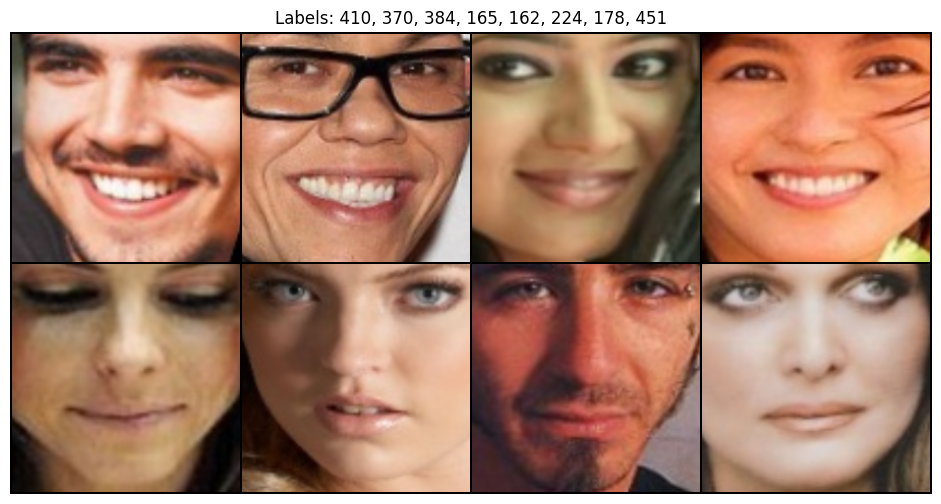

In [5]:
import matplotlib.pyplot as plt
import torchvision

# Функция для денормализации изображения (если ты использовал Normalize)
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Выводим первые N изображений из батча
def show_images(images, labels, dataset, n=8):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    images = images[:n]
    labels = labels[:n]

    images = images.clone()  # Чтобы не менять оригинал
    for i in range(images.size(0)):
        images[i] = denormalize(images[i], mean, std)

    grid_img = torchvision.utils.make_grid(images, nrow=4)
    np_img = grid_img.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(12, 6))
    plt.imshow(np_img)
    plt.axis('off')

    # Подписи — оригинальные лейблы
    label_texts = [str(label.item()) for label in labels]
    plt.title('Labels: ' + ', '.join(label_texts))
    plt.show()

# Используем первый батч из train_loader
images, labels = next(iter(train_loader))
show_images(images, labels, dataset_train)

<h1> CE loss

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import EfficientNet_B1_Weights

# Количество классов в твоем датасете
num_classes = 500

# Загружаем предобученную модель
model = models.efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V2)

# Заменяем классификатор
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=1000, bias=True),
    nn.BatchNorm1d(1000),
    nn.Linear(in_features=1000, out_features=num_classes, bias=True)
)

# Отправляем на GPU/CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [7]:
import torch.optim as optim

# Кросс-энтропия — стандартный лосс для классификации
criterion = nn.CrossEntropyLoss()

# Оптимизатор — Adam 
#optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=4e-3)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

In [8]:
start_epoch = 0
train_loss_history = []
val_loss_history = []

In [9]:
from tqdm import tqdm

num_epochs = 10

best_val_acc = float('inf')  # <-- начальный минимум
checkpoint_path = "best_model_CE.pth"


# Сохраняем начальный лернинг-рейт
initial_lr = optimizer.param_groups[0]['lr']

for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    # --- Тренировка ---
    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=correct / total)

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_loss_history.append(avg_train_loss)
    print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.4f} | Accuracy: {train_acc:.4f}")

    # --- Валидация ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_loss_history.append(avg_val_loss)
    print(f"[Epoch {epoch}] Val Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.4f}")
    start_epoch += 1

    # === Сохраняем лучшую модель ===
    if val_acc < best_val_acc:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Model saved (epoch {epoch}, val_loss={val_acc:.4f})")

    # --- Разморозка блока features[7] + уменьшение lr ---
#    if train_acc > acc_unfroze:
#        print("\n Размораживаем features[7] и уменьшаем lr в 10 раз.")
#        for param in model.features[8].parameters():
#            param.requires_grad = True

        # Переинициализация оптимизатора с меньшим lr
#        for param_group in optimizer.param_groups:
#            param_group['lr'] = param_group['lr'] * 0.1


[Epoch 0] Train Loss: 6.0705 | Accuracy: 0.0139
[Epoch 0] Val Loss: 5.5495 | Accuracy: 0.0580
Model saved (epoch 0, val_loss=0.0580)


[Epoch 1] Train Loss: 5.0703 | Accuracy: 0.1116
[Epoch 1] Val Loss: 4.7196 | Accuracy: 0.1833
Model saved (epoch 1, val_loss=0.1833)


[Epoch 2] Train Loss: 4.1030 | Accuracy: 0.2879
[Epoch 2] Val Loss: 3.8870 | Accuracy: 0.3180
Model saved (epoch 2, val_loss=0.3180)


[Epoch 3] Train Loss: 3.2297 | Accuracy: 0.4733
[Epoch 3] Val Loss: 3.1768 | Accuracy: 0.4487
Model saved (epoch 3, val_loss=0.4487)


[Epoch 4] Train Loss: 2.4857 | Accuracy: 0.6210
[Epoch 4] Val Loss: 2.6350 | Accuracy: 0.5620
Model saved (epoch 4, val_loss=0.5620)


[Epoch 5] Train Loss: 1.8859 | Accuracy: 0.7354
[Epoch 5] Val Loss: 2.2028 | Accuracy: 0.6293
Model saved (epoch 5, val_loss=0.6293)


[Epoch 6] Train Loss: 1.4228 | Accuracy: 0.8139
[Epoch 6] Val Loss: 1.8877 | Accuracy: 0.6867
Model saved (epoch 6, val_loss=0.6867)


[Epoch 7] Train Loss: 1.0547 | Accuracy: 0.8723
[Epoch 7] Val Loss: 1.6491 | Accuracy: 0.7133
Model saved (epoch 7, val_loss=0.7133)


[Epoch 8] Train Loss: 0.7835 | Accuracy: 0.9135
[Epoch 8] Val Loss: 1.4943 | Accuracy: 0.7500
Model saved (epoch 8, val_loss=0.7500)


[Epoch 9] Train Loss: 0.5772 | Accuracy: 0.9444
[Epoch 9] Val Loss: 1.3717 | Accuracy: 0.7540
Model saved (epoch 9, val_loss=0.7540)


[Epoch 10] Train Loss: 0.4241 | Accuracy: 0.9666
[Epoch 10] Val Loss: 1.2559 | Accuracy: 0.7740
Model saved (epoch 10, val_loss=0.7740)


In [22]:
# Сохраним модель
torch.save(model, 'model_CEloss.pth')

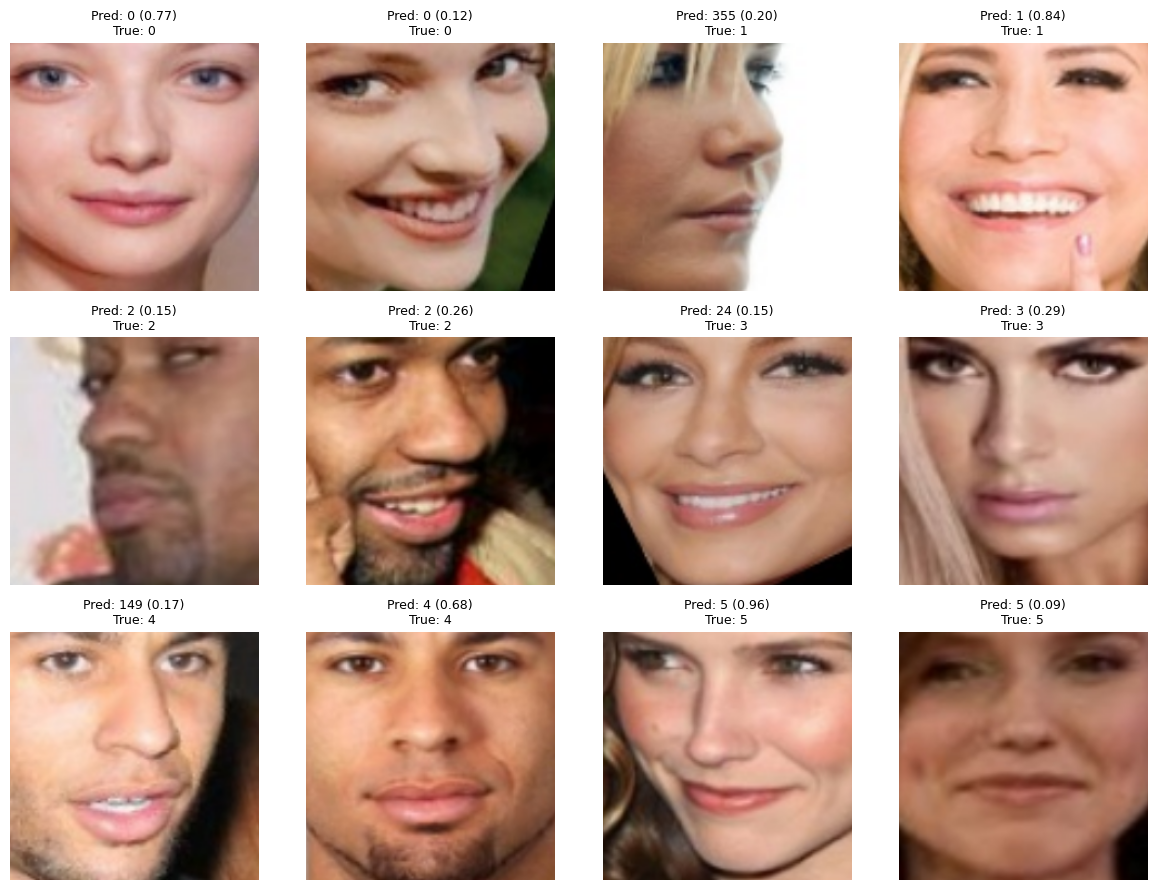

In [10]:
import torchvision.transforms as T
import torch.nn.functional as F

def visualize_test_predictions(model, dataloader, dataset, device, num_images=12, columns=4):
    model.eval()
    shown = 0

    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    rows = (num_images + columns - 1) // columns
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 3, rows * 3))
    axes = axes.flatten()

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            for i in range(images.size(0)):
                if shown >= num_images:
                    break

                image = images[i].cpu().clone()
                image = denormalize(image, mean, std)
                image = torch.clamp(image, 0, 1)
                image_vis = T.ToPILImage()(image)

                pred_label = preds[i].item()
                true_label = labels[i].item()
                confidence = probs[i, pred_label].item()

                ax = axes[shown]
                ax.imshow(image_vis)
                ax.axis('off')
                ax.set_title(f"Pred: {pred_label} ({confidence:.2f})\nTrue: {true_label}", fontsize=9)
                
                shown += 1

            if shown >= num_images:
                break

    # Отключаем лишние пустые ячейки
    for j in range(shown, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

visualize_test_predictions(model, test_loader, dataset_test, device, num_images=12)

<h1> ArcFace Loss

In [12]:
### https://github.com/ronghuaiyang/arcface-pytorch/tree/master
from torch.nn import Parameter
import math
import torch.nn.functional as F
import torch.nn as nn
import torch

class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin

            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output


In [13]:
class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.5, easy_margin=False, ls_eps=0.0):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [14]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights

arcface_model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V2)

In [15]:
class ArcFace_model(nn.Module):
    def __init__(self):
        super(ArcFace_model, self).__init__()

        self.encoding = arcface_model
        self.bn1 = nn.BatchNorm1d(1000)
        self.arcface = ArcFace(1000, 500)

    def forward(self, x, labels=None):
        x = self.encoding(x)
        x = self.bn1(x)
        if labels is not None:
            x = self.arcface(x, labels)
        return x

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
arcface_model = ArcFace_model().to(device)

optimizer = torch.optim.Adam(arcface_model.parameters())
criterion = nn.CrossEntropyLoss()

In [17]:
start_epoch = 0
train_loss_history = []
val_loss_history = []

In [18]:
from tqdm import tqdm

num_epochs = 12

best_val_acc = float('inf')
checkpoint_path = "best_model_ArcFace.pth"

for epoch in range(start_epoch, num_epochs + 1):

    arcface_model.train()
    running_loss = 0.0
    correct, total = 0, 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        #embeddings = backbone(images)                # Получаем эмбеддинги
        #outputs = arc_margin(embeddings, labels)    # Получаем логиты с ArcFace
        outputs = arcface_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=correct / total)


        
    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_loss_history.append(avg_train_loss)
    print(f"[Epoch {epoch}] Train Loss: {avg_train_loss:.4f} | Accuracy: {train_acc:.4f}")

    # --- Валидация ---

    arcface_model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            #embeddings = backbone(images)
            #outputs = arc_margin(embeddings, labels)
            outputs = arcface_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total
    val_loss_history.append(avg_val_loss)
    print(f"[Epoch {epoch}] Val Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.4f}")
    start_epoch += 1

    # === Сохраняем лучшую модель ===
    if val_acc < best_val_acc:
        best_val_loss = avg_val_loss
        torch.save(arcface_model.state_dict(), checkpoint_path)
        torch.save(arcface_model, "ArcFace_full.pth")
        print(f"Model saved (epoch {epoch}, val_loss={val_acc:.4f})")

[Epoch 0] Train Loss: 6.2789 | Accuracy: 0.0470
[Epoch 0] Val Loss: 4.8976 | Accuracy: 0.2240
Model saved (epoch 0, val_loss=0.2240)


[Epoch 1] Train Loss: 4.2686 | Accuracy: 0.3566
[Epoch 1] Val Loss: 3.2734 | Accuracy: 0.5407
Model saved (epoch 1, val_loss=0.5407)


[Epoch 2] Train Loss: 2.9020 | Accuracy: 0.6548
[Epoch 2] Val Loss: 2.1697 | Accuracy: 0.6833
Model saved (epoch 2, val_loss=0.6833)


[Epoch 3] Train Loss: 2.0136 | Accuracy: 0.8092
[Epoch 3] Val Loss: 1.6587 | Accuracy: 0.7360
Model saved (epoch 3, val_loss=0.7360)


[Epoch 4] Train Loss: 1.3414 | Accuracy: 0.9054
[Epoch 4] Val Loss: 1.2791 | Accuracy: 0.7940
Model saved (epoch 4, val_loss=0.7940)


[Epoch 5] Train Loss: 0.9281 | Accuracy: 0.9500
[Epoch 5] Val Loss: 1.0581 | Accuracy: 0.8147
Model saved (epoch 5, val_loss=0.8147)


[Epoch 6] Train Loss: 0.6541 | Accuracy: 0.9739
[Epoch 6] Val Loss: 0.9163 | Accuracy: 0.8420
Model saved (epoch 6, val_loss=0.8420)


[Epoch 7] Train Loss: 0.4867 | Accuracy: 0.9839
[Epoch 7] Val Loss: 0.8351 | Accuracy: 0.8580
Model saved (epoch 7, val_loss=0.8580)


[Epoch 8] Train Loss: 0.3993 | Accuracy: 0.9850
[Epoch 8] Val Loss: 0.8194 | Accuracy: 0.8587
Model saved (epoch 8, val_loss=0.8587)


[Epoch 9] Train Loss: 0.3334 | Accuracy: 0.9882
[Epoch 9] Val Loss: 0.7753 | Accuracy: 0.8547
Model saved (epoch 9, val_loss=0.8547)


[Epoch 10] Train Loss: 0.2834 | Accuracy: 0.9907
[Epoch 10] Val Loss: 0.8048 | Accuracy: 0.8587
Model saved (epoch 10, val_loss=0.8587)


[Epoch 11] Train Loss: 0.2544 | Accuracy: 0.9908
[Epoch 11] Val Loss: 0.7676 | Accuracy: 0.8620
Model saved (epoch 11, val_loss=0.8620)


[Epoch 12] Train Loss: 0.2266 | Accuracy: 0.9914
[Epoch 12] Val Loss: 0.7343 | Accuracy: 0.8673
Model saved (epoch 12, val_loss=0.8673)


In [19]:
# Сохраним модель
torch.save(arcface_model, 'model_ArcFace.pth')

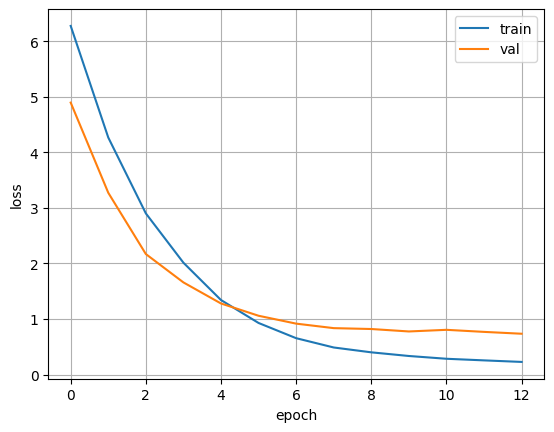

In [20]:
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.show()

# Conclusion:
Обучена модель face recognition на CE loss и на ArcFace loss (efficientnet b1 - бэкбон без предобучения на лицах). Точность классификации (на CE и ArcFace): 77.4% и 86.9%.

Для обоих моделей крайне важен face alignment. С ошибкой на это шаге удавалось с трудом достичь точности 70% на CE loss. В то же время модель на основе arcface совсем не училась (точность была около 20%)